In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('Comcast_telecom_complaints_data.csv')
df.head()

,Ticket #,Customer Complaint,Date,Date_month_year,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone
0,250635,Comcast Cable Internet Speeds,22-04-15,22-Apr-15,3:53:50 PM,Customer Care Call,Abingdon,Maryland,21009,Closed,No
1,223441,Payment disappear - service got disconnected,04-08-15,04-Aug-15,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No
2,242732,Speed and Service,18-04-15,18-Apr-15,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,05-07-15,05-Jul-15,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes
4,307175,Comcast not working and no service to boot,26-05-15,26-May-15,1:25:26 PM,Internet,Acworth,Georgia,30101,Solved,No


In [3]:
df['Customer Complaint'].head()

0                        Comcast Cable Internet Speeds
1         Payment disappear - service got disconnected
2                                    Speed and Service
3    Comcast Imposed a New Usage Cap of 300GB that ...
4           Comcast not working and no service to boot
Name: Customer Complaint, dtype: object

In [4]:
df['length'] = df['Customer Complaint'].str.len()

## Show summary statistics

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Zip code,2224.0,47994.393435,28885.279427,1075.0,30056.5,37211.0,77058.75,99223.0
length,2224.0,30.996403,19.382296,3.0,17.0,26.0,40.00,147.0


In [6]:
df.describe(include='O').T

,count,unique,top,freq
Ticket #,2224,2224,250635,1
Customer Complaint,2224,1841,Comcast,83
Date,2224,91,24-06-15,218
Date_month_year,2224,91,24-Jun-15,218
Time,2224,2190,12:41:14 PM,2
Received Via,2224,2,Customer Care Call,1119
City,2224,928,Atlanta,63
State,2224,43,Georgia,288
Status,2224,4,Solved,973
Filing on Behalf of Someone,2224,2,No,2021


In [7]:
# df.info()

## Check for missing data

In [8]:
df.isna().sum()

Ticket #                       0
Customer Complaint             0
Date                           0
Date_month_year                0
Time                           0
Received Via                   0
City                           0
State                          0
Zip code                       0
Status                         0
Filing on Behalf of Someone    0
length                         0
dtype: int64

## Plot value distributions

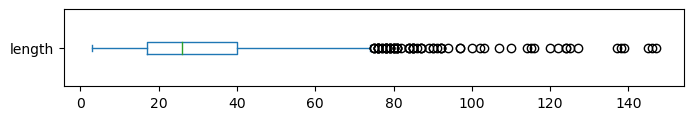

In [9]:
df['length'].plot(kind='box', vert=False, figsize=(8, 1));

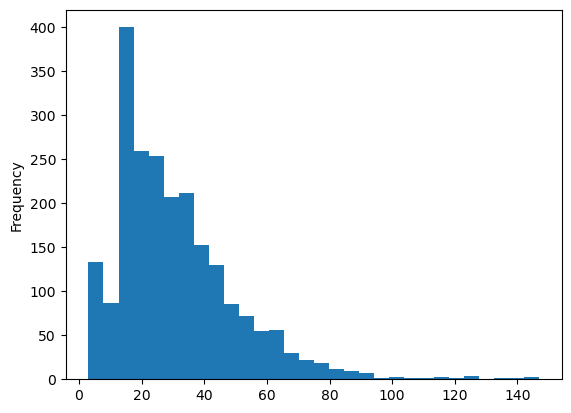

In [10]:
df['length'].plot(kind='hist', bins=30);

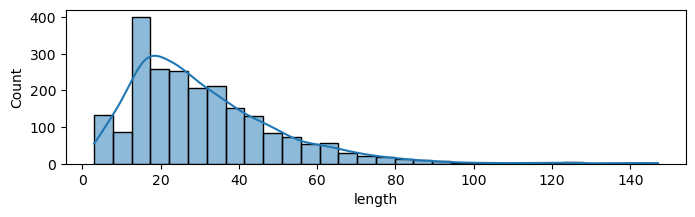

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 2))
sns.histplot(df['length'], bins=30, kde=True);

## Comparing Value distributions across categories

In [12]:
df.head(3)

,Ticket #,Customer Complaint,Date,Date_month_year,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone,length
0,250635,Comcast Cable Internet Speeds,22-04-15,22-Apr-15,3:53:50 PM,Customer Care Call,Abingdon,Maryland,21009,Closed,No,29
1,223441,Payment disappear - service got disconnected,04-08-15,04-Aug-15,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No,44
2,242732,Speed and Service,18-04-15,18-Apr-15,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes,17


In [13]:
df['State'].unique()

array(['Maryland', 'Georgia', 'Michigan', 'California', 'New Mexico',
       'Indiana', 'Virginia', 'Illinois', 'Pennsylvania', 'Massachusetts',
       'Oregon', 'Texas', 'New Hampshire', 'Minnesota', 'Tennessee',
       'Colorado', 'Florida', 'Alabama', 'Washington', 'New York',
       'New Jersey', 'Maine', 'Missouri', 'West Virginia', 'Montana',
       'Mississippi', 'Connecticut', 'Vermont', 'Kentucky',
       'South Carolina', 'Ohio', 'Utah', 'Delaware', 'Arkansas', 'Nevada',
       'Louisiana', 'Kansas', 'Arizona', 'North Carolina', 'Rhode Island',
       'District Of Columbia', 'District of Columbia', 'Iowa'],
      dtype=object)

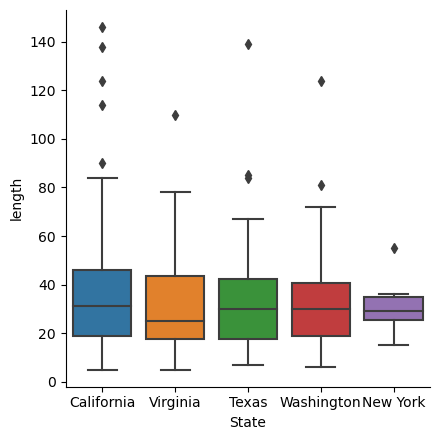

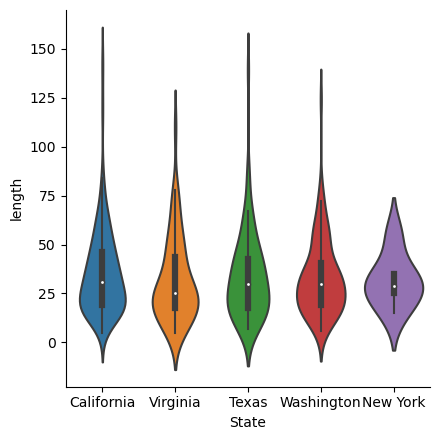

In [14]:
import seaborn as sns
where = df['State'].isin(['New York', 'Washington', 'Texas', 'Virginia', 'California'])
f = sns.catplot(data=df[where], x="State", y="length", kind='box', height=4.5)
f = sns.catplot(data=df[where], x="State", y="length", kind='violin', height=4.5);

## Visualize complaints over time

In [15]:
df['Datetime'] = pd.to_datetime(df['Date']).dt.date

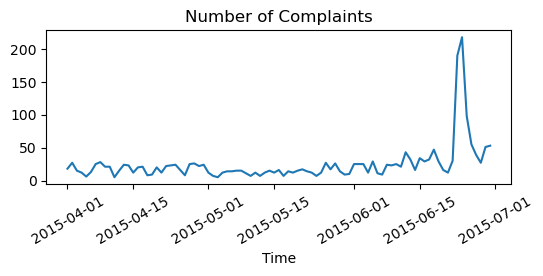

In [16]:
df.groupby('Datetime').size().plot(xlabel='Time',rot=30, title="Number of Complaints", figsize=(6,2));

## Text Preprocessing

In [17]:
import regex as re
def tokenize(text):
    return re.findall('[\w-]*\p{L}[\w-]*', text)

import nltk
stopwords = set(nltk.corpus.stopwords.words('english'))

def remove_stopwords(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [18]:
# Create a pipeline to process text 
pipeline = [str.lower, tokenize, remove_stopwords]

def preprocess(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [19]:
df.rename(columns={'Customer Complaint': 'text'}, inplace=True)

In [20]:
df['tokens'] = df['text'].apply(preprocess, pipeline=pipeline)
df[['text', 'tokens']][2:5]

,text,tokens
2,Speed and Service,"[speed, service]"
3,Comcast Imposed a New Usage Cap of 300GB that ...,"[comcast, imposed, new, usage, cap, 300gb, pun..."
4,Comcast not working and no service to boot,"[comcast, working, service, boot]"


## Analyze word frequency

In [21]:
from collections import Counter

def word_counter(df, column='tokens', preprocess=None, min_count=2):
    
    # preprocess text and update counter
    def update(text):
        tokens = text if preprocess is None else preprocess(text)
        counter.update(tokens)
    
    # create counter and run through all text data
    counter = Counter()
    df[column].map(update)
    
    # transform counter into a DataFrame
    count_df = pd.DataFrame.from_dict(counter, orient='index', columns=['frequency'])
    count_df = count_df.query('frequency >= @min_count') # remove words with frequency less than or equal to min_count
    count_df.index.name = 'token'
    
    return count_df.sort_values('frequency', ascending=False)

In [22]:
count_df = word_counter(df)
count_df.head()

,frequency
token,
comcast,1237
internet,533
service,455
billing,292
data,219


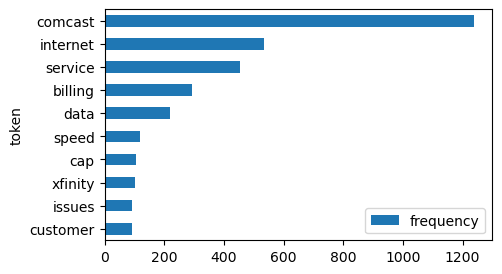

In [23]:
# Plot a frequency diagram
count_df.head(10).plot(kind='barh', figsize=(5,3)).invert_yaxis()

## Create Word Clouds

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(word_frequency, title=None, max_words=200, stopwords=None):

    wc = WordCloud(colormap="Paired", max_words=max_words)

    # Convert DataFrame into Dict
    if type(word_frequency) == pd.Series:
        counter = Counter(word_frequency.fillna(0).to_dict())
    else:
        counter = word_frequency

    # filter stop words in frequency counter rather than filtering with wordcloud module
    if stopwords is not None:
        counter = {token:count for (token, count) in counter.items() \
                               if token not in stopwords}

    wc.generate_from_frequencies(counter)  # counter should be as dictionary !!

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off');

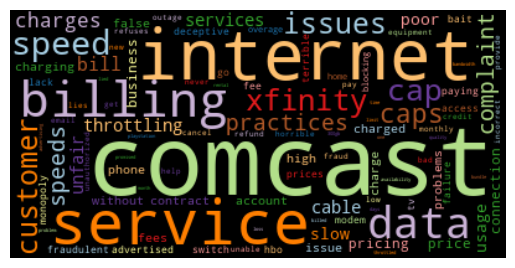

In [27]:
plot_wordcloud(count_df['frequency'], max_words=100)

In [28]:
count_df.head(20).index

Index(['comcast', 'internet', 'service', 'billing', 'data', 'speed', 'cap',
       'xfinity', 'issues', 'customer', 'caps', 'practices', 'speeds',
       'complaint', 'charges', 'bill', 'unfair', 'cable', 'services',
       'throttling'],
      dtype='object', name='token')

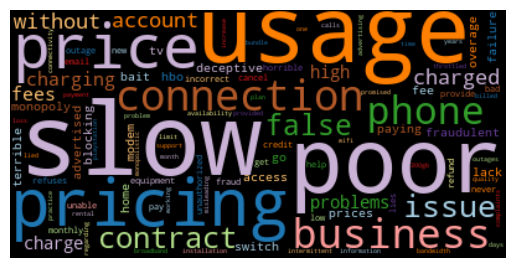

In [30]:
# remove the top 20 frequent words
plot_wordcloud(count_df['frequency'], max_words=100, stopwords=count_df.head(20).index)

## Ranking with TF-IDF

In [31]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(text):
        tokens = text if preprocess is None else preprocess(text)
        counter.update(set(tokens))  # only count the word once (even if repeated) for each document

    # count tokens
    counter = Counter()
    df[column].map(update)

    # create DataFrame and compute IDF
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query("df >= @min_df")
    idf_df['idf'] = np.log( len(df)/idf_df['df'] ) + 0.1
    idf_df.index.name = 'token'

    return idf_df

idf_df = compute_idf(df)

/var/folders/9g/_31yc5b92m96cxdj9hkt6kd80000gn/T/ipykernel_12562/1067336138.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log( len(df)/idf_df['df'] ) + 0.1


In [32]:
# compute TF-IDF
count_df['tfidf'] = count_df['frequency'] * idf_df['idf']
count_df.head()

,frequency,tfidf
token,,
comcast,1237,851.348435
internet,533,818.727561
service,455,784.803904
billing,292,624.057066
data,219,530.542303


## Analysing N-grams

In [34]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
                            if len([t for t in ngram if t in stopwords])==0]

In [37]:
# df['bigrams'] = df['text'].apply(preprocess, pipeline=[str.lower, tokenize]) \
#                           .apply(ngrams, n=2, stopwords=stopwords)

df['bigrams'] = df['tokens'].apply(ngrams, n=2, stopwords=stopwords)

word_counter(df, 'bigrams').head(8)

,frequency
token,
comcast internet,129
comcast data,104
internet service,89
data cap,81
customer service,76
comcast billing,74
data caps,66
comcast xfinity,63


In [38]:
idf_df = compute_idf(df)
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=5)])

count_df = word_counter(df, 'bigrams')
count_df['tfidf_bigrams'] = count_df['frequency'] * idf_df['idf']  # frequency column is overwritten for bigrams

/var/folders/9g/_31yc5b92m96cxdj9hkt6kd80000gn/T/ipykernel_12562/1067336138.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log( len(df)/idf_df['df'] ) + 0.1
/var/folders/9g/_31yc5b92m96cxdj9hkt6kd80000gn/T/ipykernel_12562/1067336138.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log( len(df)/idf_df['df'] ) + 0.1


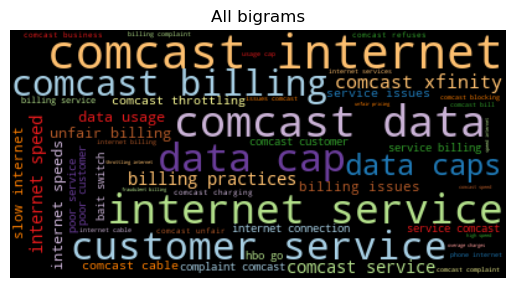

In [41]:
plot_wordcloud(count_df['tfidf_bigrams'], title='All bigrams', max_words=50)

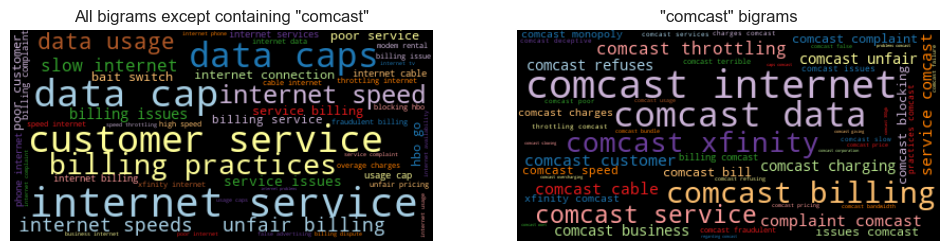

In [130]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
where = count_df.index.str.contains('comcast')
# plot_wordcloud(count_df['tfidf_bigrams'], title='All bigrams', max_words=50)
plot_wordcloud(count_df[~where]['frequency'], title='All bigrams except containing "comcast"', max_words=50)

plt.subplot(1,2,2) ###
# plt.tight_layout() ###
where = count_df.index.str.contains('comcast')
plot_wordcloud(count_df[where]['frequency'], title='"comcast" bigrams', max_words=50)

## Comparing Frequencies of Categories across Time-Intervals

In [103]:
def count_keywords(tokens, keywords): 
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [104]:
def count_keywords_by(df, by, keywords, column='tokens'):
    df = df.reset_index(drop=True) # if the supplied dataframe has gaps in the index
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    count_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    count_df[by] = df[by] # copy the grouping column(s)
    
    return count_df.groupby(by=by).sum().sort_values(by)

In [105]:
df['num_tokens'] = df['bigrams'].map(len)

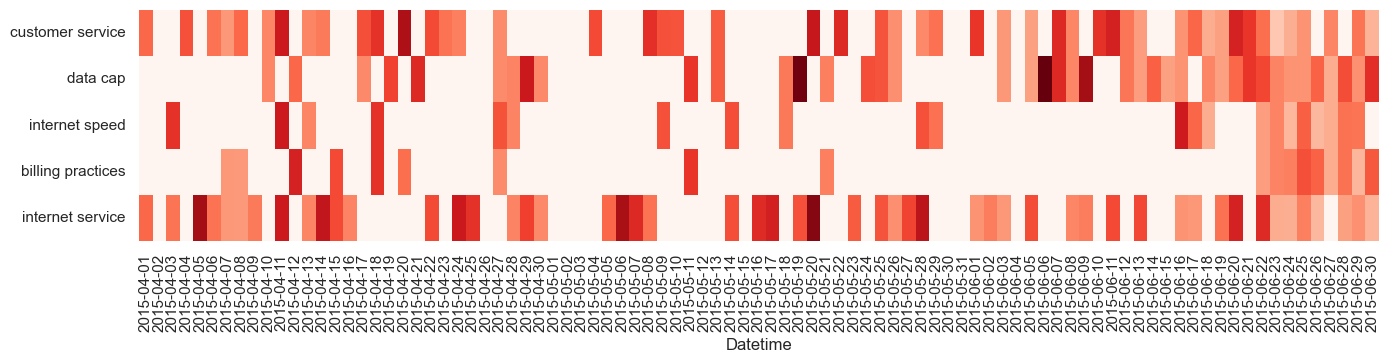

In [114]:
keywords = ['customer service', 'data cap', 'internet speed', 'billing practices', 'internet service']  

keyword_count_df = count_keywords_by(df, by='Datetime', keywords=keywords, column='bigrams')

# compute relative frequencies based on total number of tokens per year
keyword_count_df = keyword_count_df.div(df.groupby('Datetime')['num_tokens'].sum(), axis=0)
# apply square root as sublinear filter for better contrast
keyword_count_df = keyword_count_df.apply(np.sqrt)

plt.figure(figsize=(16, 3))
sns.heatmap(data=keyword_count_df.T, xticklabels=True, yticklabels=True, cbar=False, cmap="Reds");